# NASA Exoplanet Mass Prediction

This notebook predict Mass of a exoplanet using NASA Exoplanet Archive data

# Import Libraries and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from scipy.stats import jarque_bera, normaltest, shapiro, chi2_contingency
from statsmodels.stats.diagnostic import het_white, het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, QuantileTransformer, PolynomialFeatures, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_regression, RFE, RFECV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, VotingRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.inspection import permutation_importance
import itertools
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
np.random.seed(42)

# Data Loading and Initial Inspection

In [2]:
url = "https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select+*+from+ps&format=csv"
df = pd.read_csv(url)

print(f"Dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\nColumn Data Types:")
print(df.dtypes.value_counts())

target_col = 'pl_bmasse'
print(f"\nTarget variable '{target_col}' statistics:")
print(df[target_col].describe())

Dataset shape: (38898, 354)
Memory usage: 291.88 MB

Column Data Types:
float64    239
object      89
int64       26
Name: count, dtype: int64

Target variable 'pl_bmasse' statistics:
count     6866.000000
mean       710.053607
std       1451.794928
min          0.015000
25%         13.300000
50%        190.000000
75%        664.979818
max      25426.400000
Name: pl_bmasse, dtype: float64


# Data Quality Assessment and Missing Value Analysis

In [3]:
missing_stats = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df)) * 100,
    'Data_Type': df.dtypes
})
missing_stats = missing_stats[missing_stats['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)

relevant_features = ['pl_bmasse', 'pl_rade', 'pl_orbper', 'pl_orbsmax', 'pl_eqt',
                    'st_mass', 'st_rad', 'st_teff', 'st_met', 'st_age', 'st_dens',
                    'pl_dens', 'discoverymethod', 'disc_year', 'sy_dist']

df_filtered = df[relevant_features].copy()

df_clean = df_filtered.dropna(subset=[target_col])

numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df_clean.select_dtypes(include=['object']).columns.tolist()

for col in numeric_cols:
    if col != target_col:
        df_clean[col].fillna(df_clean[col].median(), inplace=True)

for col in categorical_cols:
    df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)

print(f"Clean dataset shape: {df_clean.shape}")
print(f"Remaining missing values: {df_clean.isnull().sum().sum()}")

Clean dataset shape: (6866, 15)
Remaining missing values: 0


# Exploratory Data Analysis

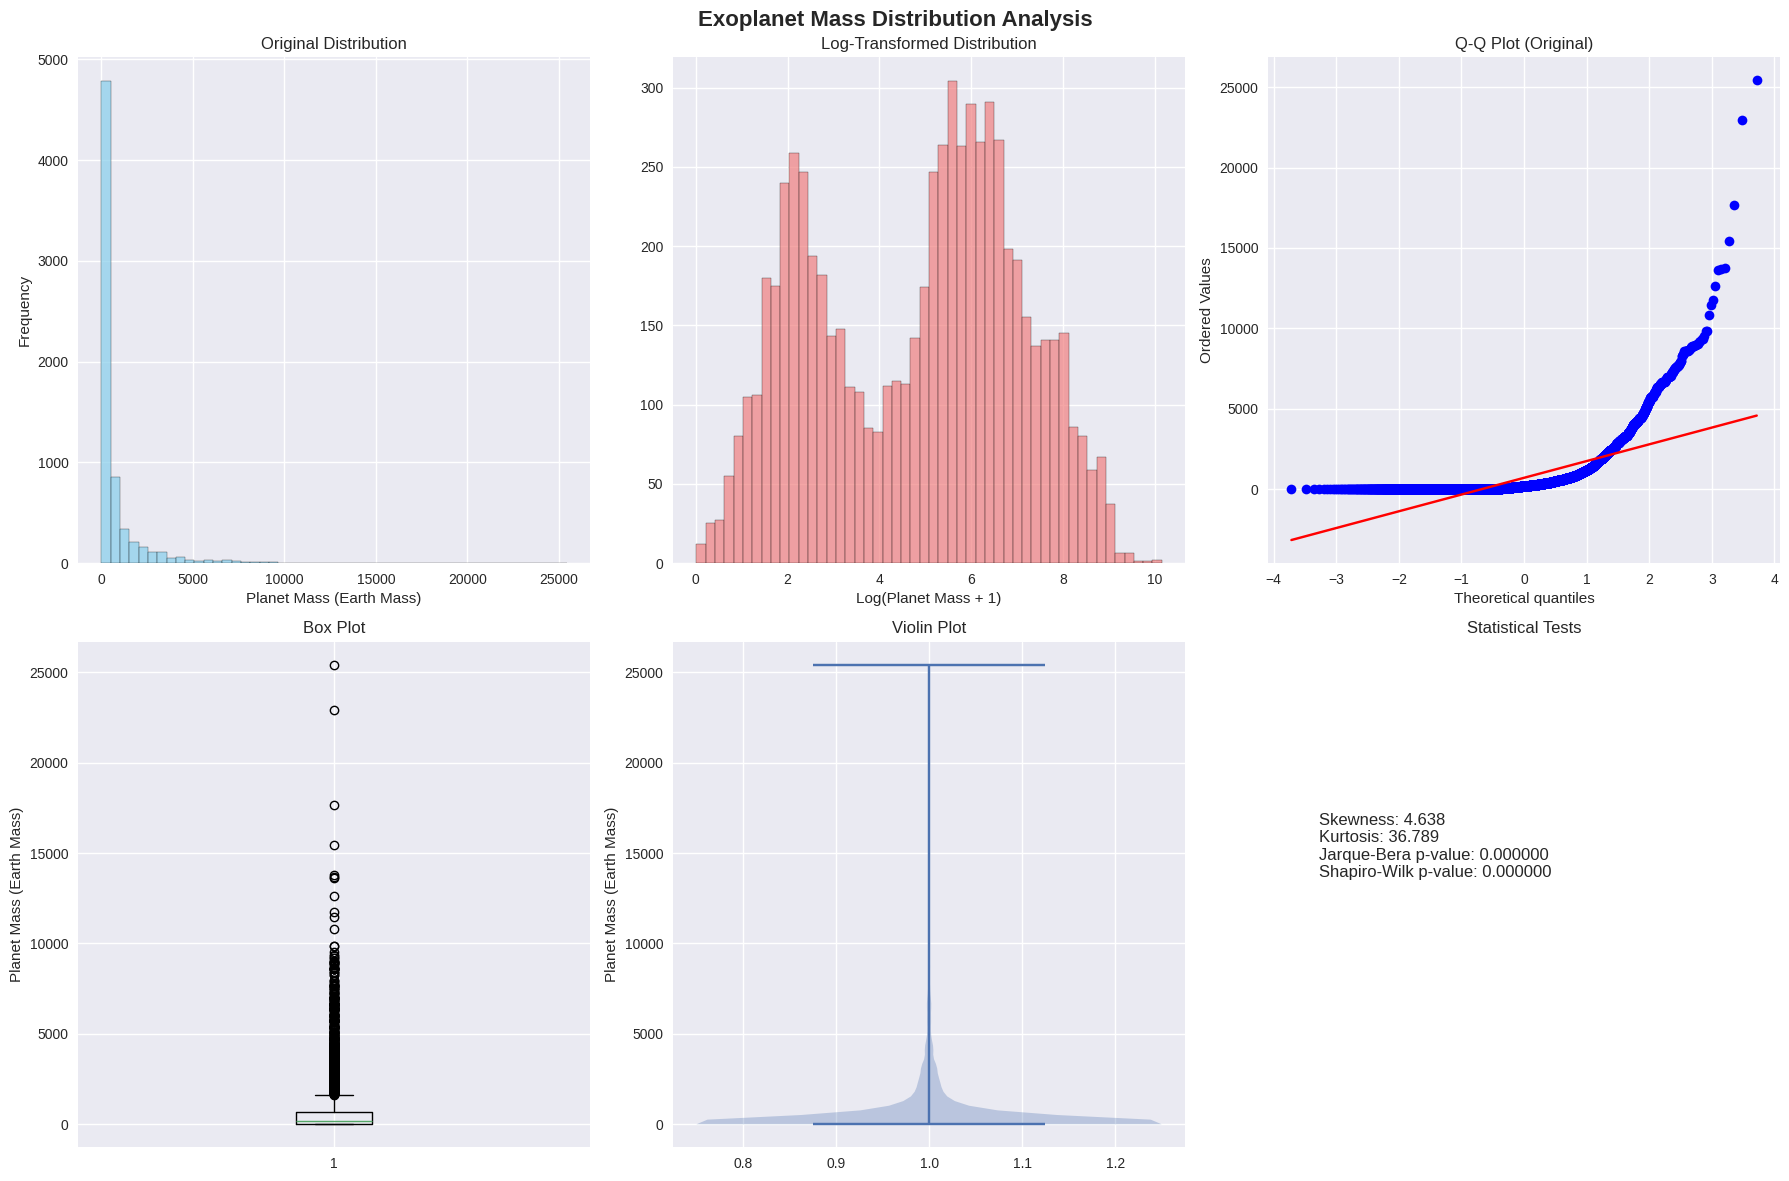

In [4]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Exoplanet Mass Distribution Analysis', fontsize=16, fontweight='bold')

axes[0,0].hist(df_clean[target_col], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Original Distribution')
axes[0,0].set_xlabel('Planet Mass (Earth Mass)')
axes[0,0].set_ylabel('Frequency')

log_target = np.log1p(df_clean[target_col])
axes[0,1].hist(log_target, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0,1].set_title('Log-Transformed Distribution')
axes[0,1].set_xlabel('Log(Planet Mass + 1)')

stats.probplot(df_clean[target_col], dist="norm", plot=axes[0,2])
axes[0,2].set_title('Q-Q Plot (Original)')

axes[1,0].boxplot(df_clean[target_col])
axes[1,0].set_title('Box Plot')
axes[1,0].set_ylabel('Planet Mass (Earth Mass)')

axes[1,1].violinplot(df_clean[target_col])
axes[1,1].set_title('Violin Plot')
axes[1,1].set_ylabel('Planet Mass (Earth Mass)')

stats_text = f"""
Skewness: {stats.skew(df_clean[target_col]):.3f}
Kurtosis: {stats.kurtosis(df_clean[target_col]):.3f}
Jarque-Bera p-value: {jarque_bera(df_clean[target_col])[1]:.6f}
Shapiro-Wilk p-value: {shapiro(df_clean[target_col])[1]:.6f}
"""
axes[1,2].text(0.1, 0.5, stats_text, fontsize=12, transform=axes[1,2].transAxes)
axes[1,2].set_title('Statistical Tests')
axes[1,2].axis('off')

plt.tight_layout()
plt.show()

# Correlation Analysis and Feature Relationships

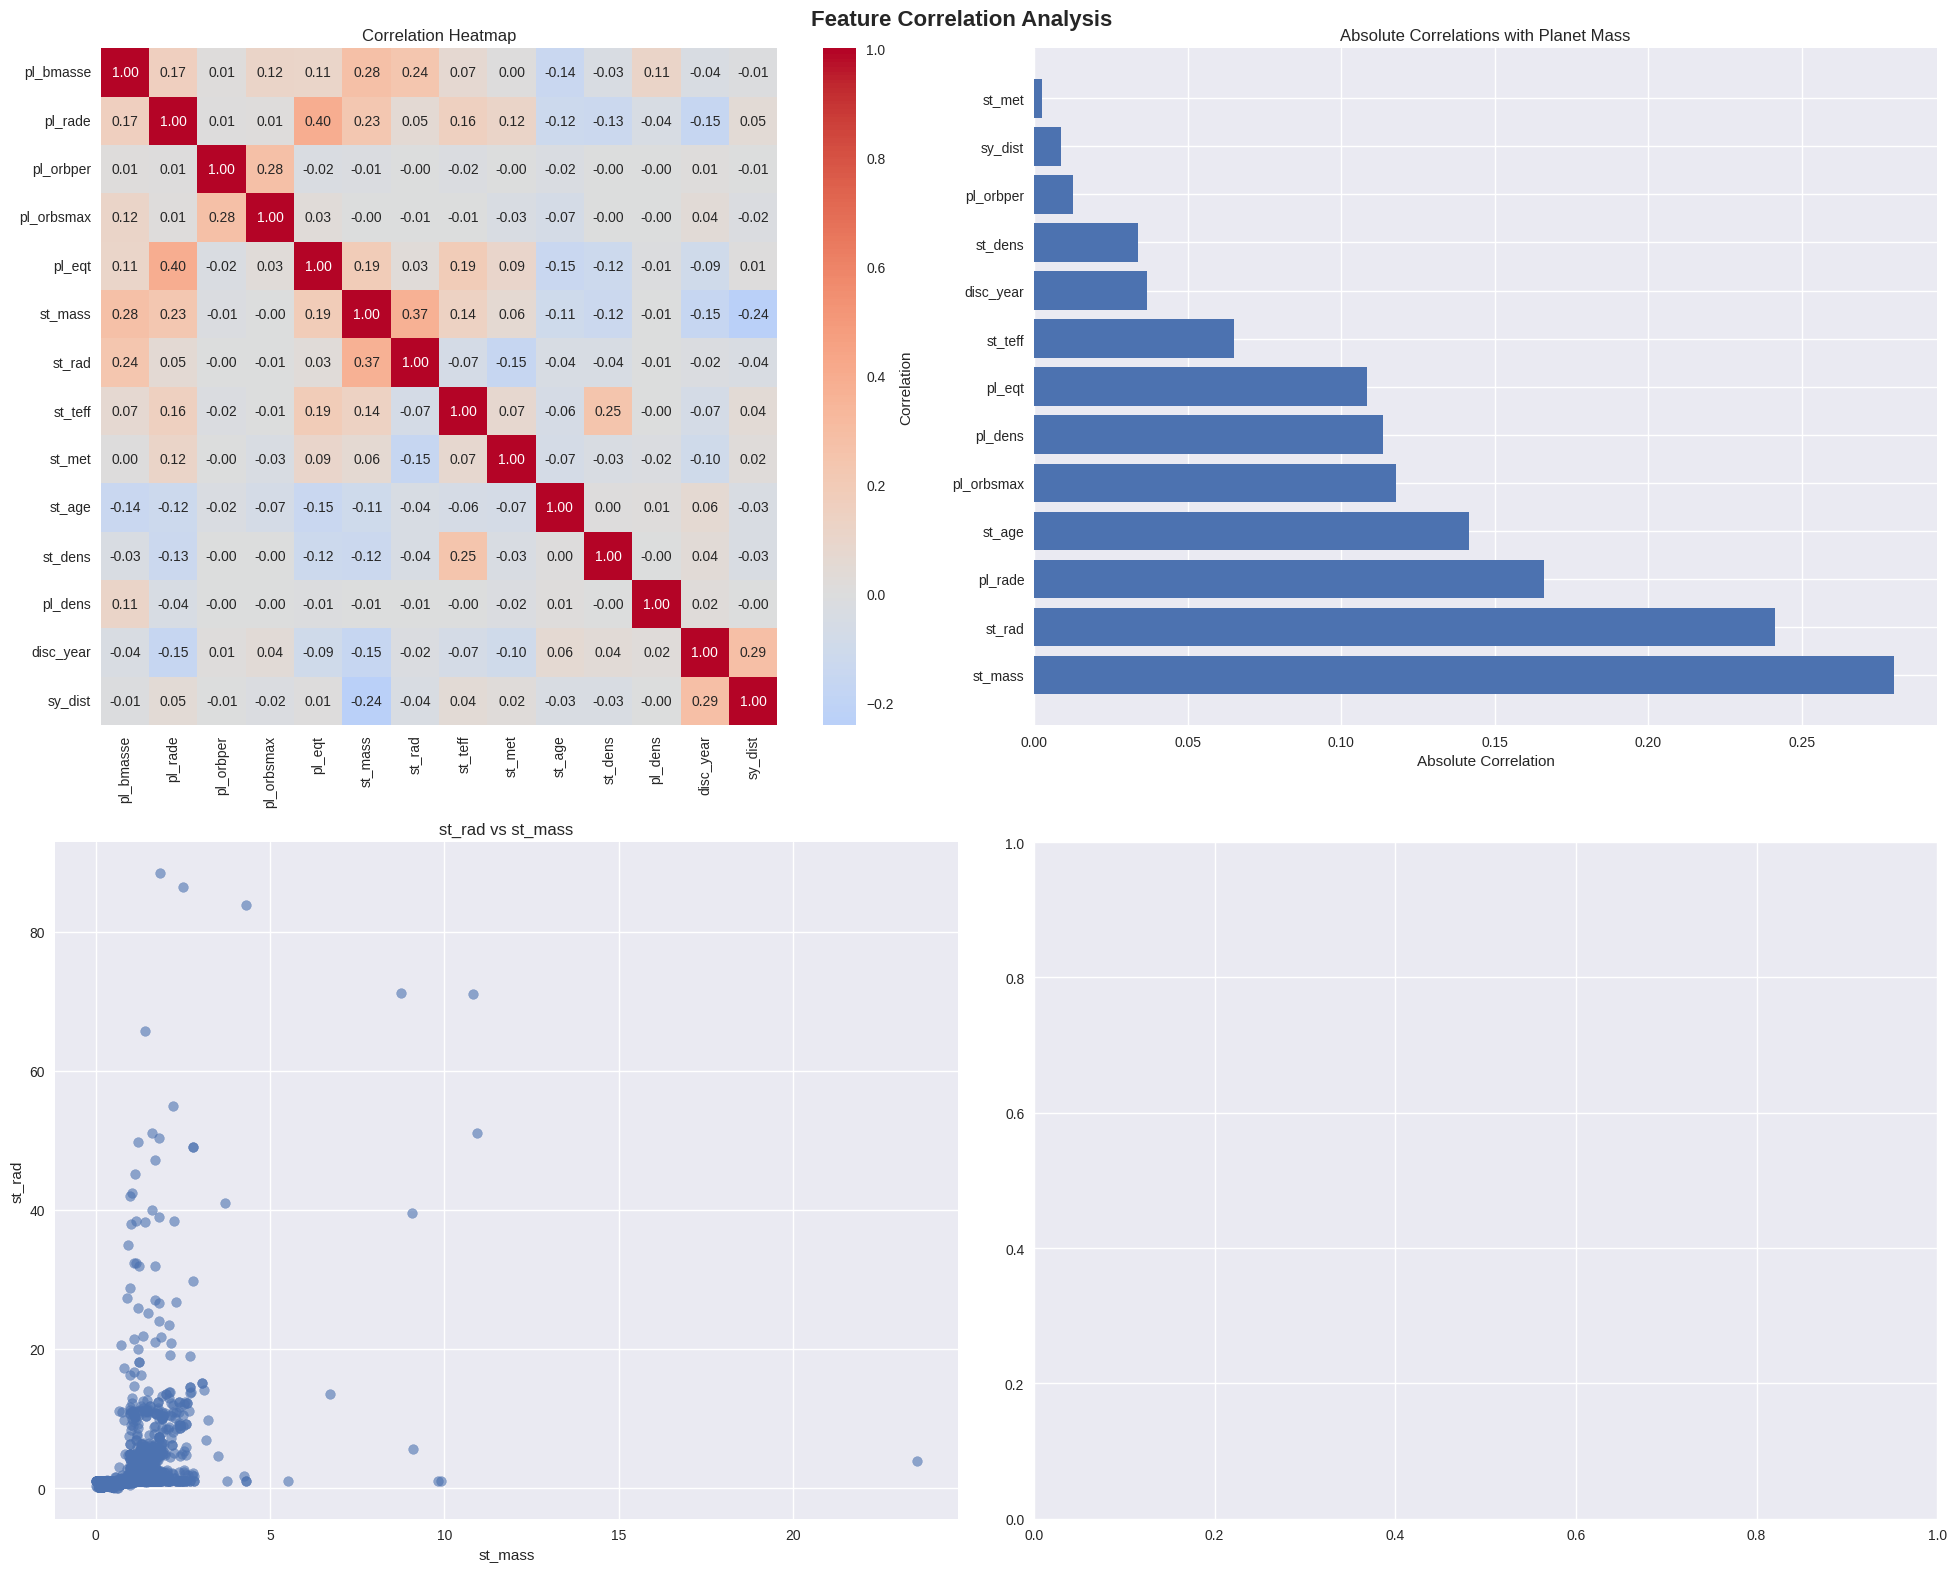

Top 5 features correlated with Planet Mass:
1. st_mass: 0.280
2. st_rad: 0.241
3. pl_rade: 0.166
4. st_age: 0.142
5. pl_orbsmax: 0.118


In [5]:
numeric_df = df_clean.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()

fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Feature Correlation Analysis', fontsize=16, fontweight='bold')

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, ax=axes[0,0], fmt='.2f', cbar_kws={'label': 'Correlation'})
axes[0,0].set_title('Correlation Heatmap')

target_corr = correlation_matrix[target_col].abs().sort_values(ascending=False)[1:]
axes[0,1].barh(range(len(target_corr)), target_corr.values)
axes[0,1].set_yticks(range(len(target_corr)))
axes[0,1].set_yticklabels(target_corr.index)
axes[0,1].set_title('Absolute Correlations with Planet Mass')
axes[0,1].set_xlabel('Absolute Correlation')

top_features = target_corr.head(4).index.tolist() + [target_col]
scatter_data = df_clean[top_features]

for i, feat1 in enumerate(top_features[:-1]):
    for j, feat2 in enumerate(top_features[:-1]):
        if i == j:
            continue
        if i < 2 and j < 2:
            row, col = i, j if j < i else j + 1
            if col < 2:
                axes[1, col].scatter(scatter_data[feat2], scatter_data[feat1], alpha=0.6)
                axes[1, col].set_xlabel(feat2)
                axes[1, col].set_ylabel(feat1)
                axes[1, col].set_title(f'{feat1} vs {feat2}')

plt.tight_layout()
plt.show()

print("Top 5 features correlated with Planet Mass:")
for i, (feature, corr) in enumerate(target_corr.head(5).items()):
    print(f"{i+1}. {feature}: {corr:.3f}")

# Categorical Feature Analysis

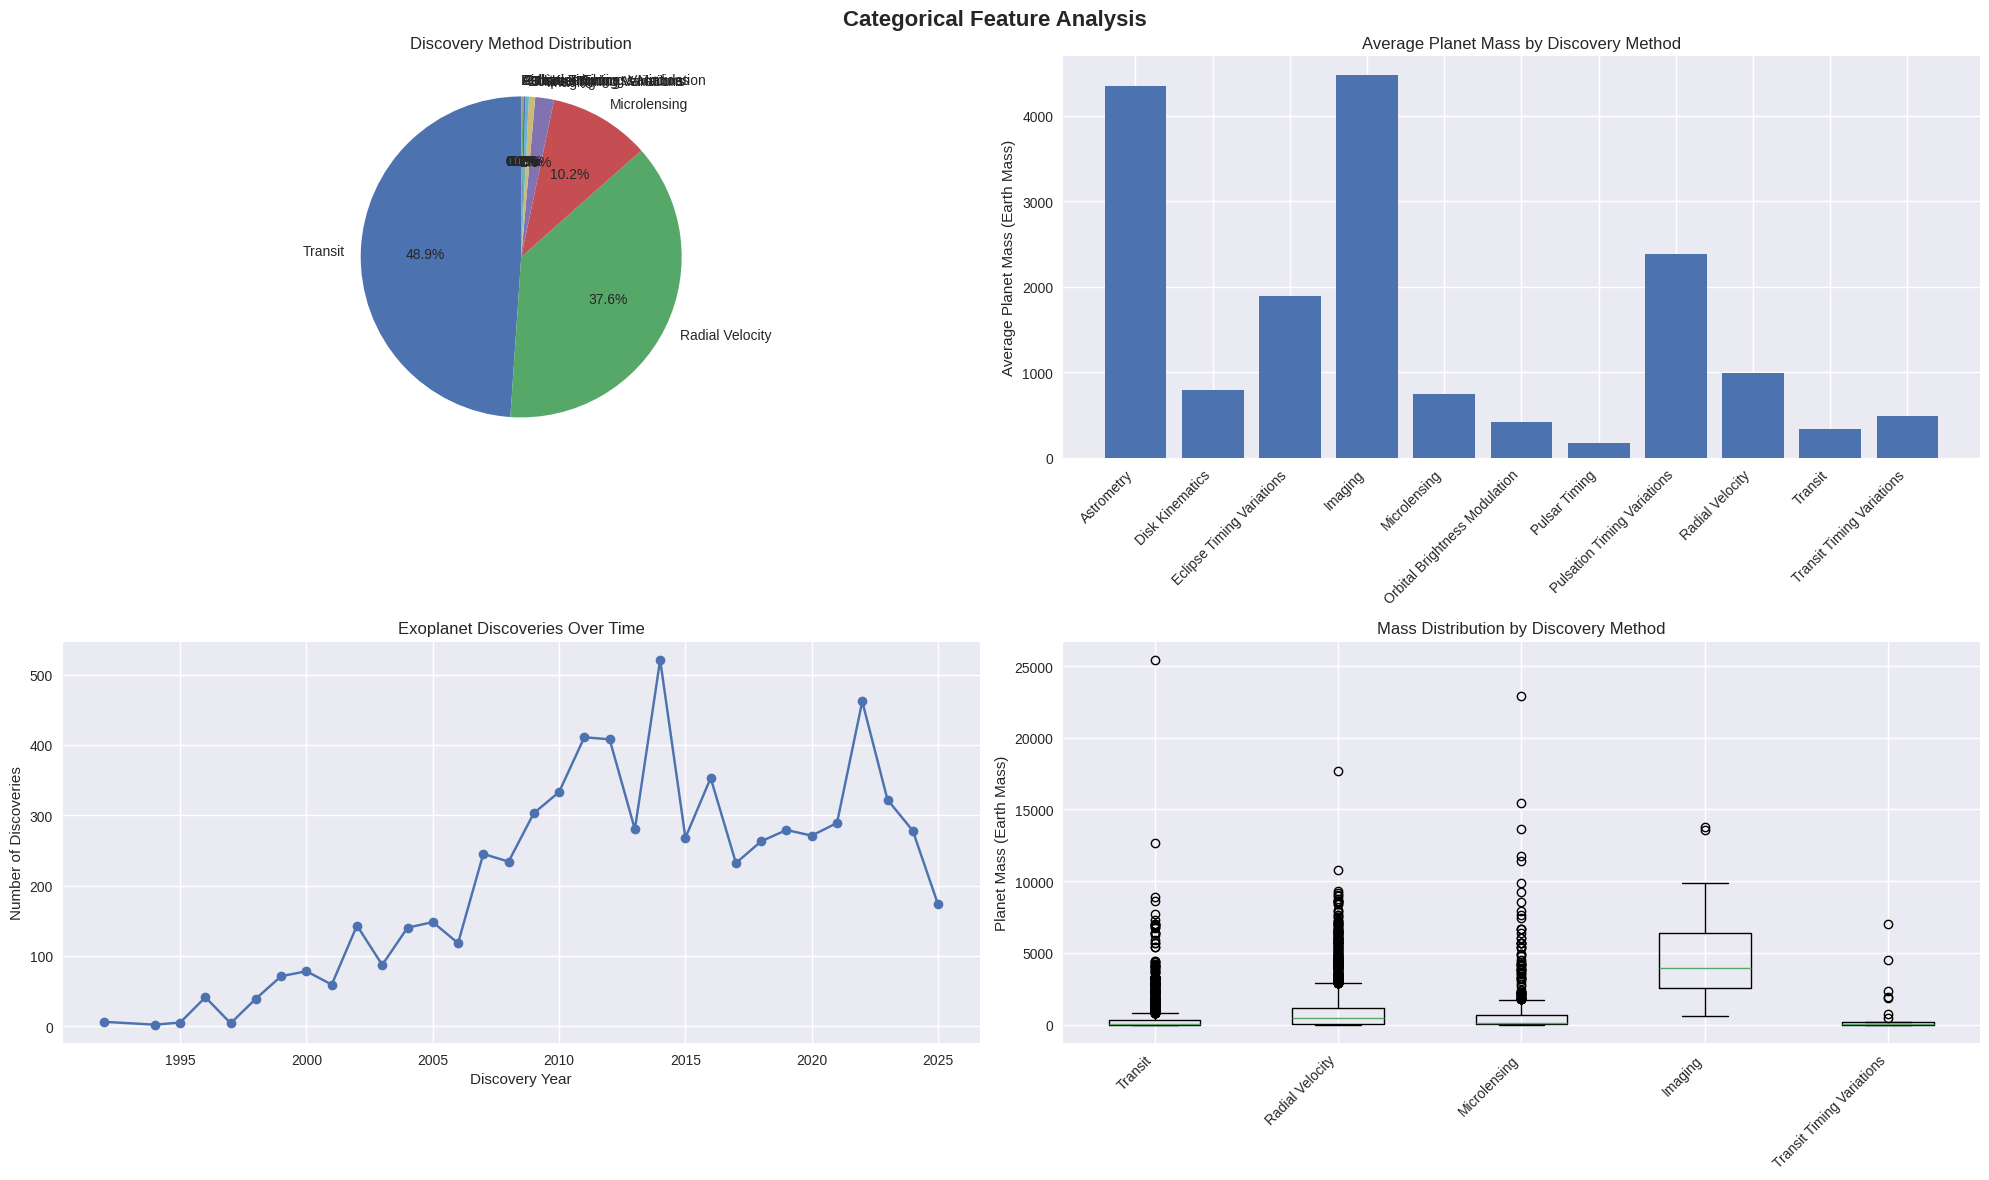

ANOVA F-statistic: 363.508, p-value: 0.000000


In [6]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('Categorical Feature Analysis', fontsize=16, fontweight='bold')

discovery_counts = df_clean['discoverymethod'].value_counts()
axes[0,0].pie(discovery_counts.values, labels=discovery_counts.index, autopct='%1.1f%%', startangle=90)
axes[0,0].set_title('Discovery Method Distribution')

discovery_mass = df_clean.groupby('discoverymethod')[target_col].agg(['mean', 'median', 'std', 'count'])
axes[0,1].bar(range(len(discovery_mass)), discovery_mass['mean'])
axes[0,1].set_xticks(range(len(discovery_mass)))
axes[0,1].set_xticklabels(discovery_mass.index, rotation=45, ha='right')
axes[0,1].set_title('Average Planet Mass by Discovery Method')
axes[0,1].set_ylabel('Average Planet Mass (Earth Mass)')

yearly_discovery = df_clean['disc_year'].value_counts().sort_index()
axes[1,0].plot(yearly_discovery.index, yearly_discovery.values, marker='o')
axes[1,0].set_title('Exoplanet Discoveries Over Time')
axes[1,0].set_xlabel('Discovery Year')
axes[1,0].set_ylabel('Number of Discoveries')

discovery_methods = df_clean['discoverymethod'].value_counts().head(5).index
filtered_data = df_clean[df_clean['discoverymethod'].isin(discovery_methods)]
box_data = [filtered_data[filtered_data['discoverymethod'] == method][target_col].values
            for method in discovery_methods]
axes[1,1].boxplot(box_data, labels=discovery_methods)
axes[1,1].set_xticklabels(discovery_methods, rotation=45, ha='right')
axes[1,1].set_title('Mass Distribution by Discovery Method')
axes[1,1].set_ylabel('Planet Mass (Earth Mass)')

plt.tight_layout()
plt.show()

f_stat, p_value = stats.f_oneway(*box_data)
print(f"ANOVA F-statistic: {f_stat:.3f}, p-value: {p_value:.6f}")

# Advanced Feature Engineering

In [7]:
df_engineered = df_clean.copy()

df_engineered['mass_radius_ratio'] = df_engineered['pl_bmasse'] / (df_engineered['pl_rade'] ** 3)
df_engineered['stellar_planet_mass_ratio'] = df_engineered['st_mass'] / df_engineered['pl_bmasse']
df_engineered['orbital_velocity'] = np.sqrt(df_engineered['st_mass'] / df_engineered['pl_orbsmax'])
df_engineered['escape_velocity'] = np.sqrt(2 * df_engineered['pl_bmasse'] / df_engineered['pl_rade'])
df_engineered['hill_sphere'] = df_engineered['pl_orbsmax'] * (df_engineered['pl_bmasse'] / (3 * df_engineered['st_mass'])) ** (1/3)

df_engineered['stellar_age_category'] = pd.cut(df_engineered['st_age'],
                                              bins=[0, 1, 5, 10, float('inf')],
                                              labels=['Young', 'Mature', 'Old', 'Ancient'])

df_engineered['planet_star_temp_ratio'] = df_engineered['pl_eqt'] / df_engineered['st_teff']

df_engineered['distance_category'] = pd.cut(df_engineered['sy_dist'],
                                           bins=[0, 100, 500, 1000, float('inf')],
                                           labels=['Near', 'Intermediate', 'Far', 'Very_Far'])

df_engineered['log_orbital_period'] = np.log1p(df_engineered['pl_orbper'])
df_engineered['sqrt_orbital_distance'] = np.sqrt(df_engineered['pl_orbsmax'])

df_engineered['mass_temp_interaction'] = df_engineered['st_mass'] * df_engineered['pl_eqt']
df_engineered['radius_period_interaction'] = df_engineered['pl_rade'] * df_engineered['pl_orbper']
df_engineered['stellar_mass_metallicity'] = df_engineered['st_mass'] * df_engineered['st_met']

poly_features = ['pl_rade', 'st_mass', 'pl_orbper']
for feature in poly_features:
    df_engineered[f'{feature}_squared'] = df_engineered[feature] ** 2
    df_engineered[f'{feature}_cubed'] = df_engineered[feature] ** 3

df_engineered['density_ratio'] = df_engineered['pl_dens'] / df_engineered['st_dens']
df_engineered['log_planet_density'] = np.log1p(df_engineered['pl_dens'])

print(f"Original features: {df_clean.shape[1]}")
print(f"Engineered features: {df_engineered.shape[1]}")
print(f"New features added: {df_engineered.shape[1] - df_clean.shape[1]}")

Original features: 15
Engineered features: 36
New features added: 21


# Data Preprocessing Pipeline

In [8]:
X = df_engineered.drop(columns=[target_col])
y = df_engineered[target_col]

categorical_features = X.select_dtypes(include=['object', 'category']).columns
label_encoders = {}

for col in categorical_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=None)

scalers = {
    'standard': StandardScaler(),
    'minmax': MinMaxScaler(),
    'robust': RobustScaler(),
    'power': PowerTransformer(method='yeo-johnson'),
    'quantile': QuantileTransformer(output_distribution='normal')
}

scaled_data = {}
for name, scaler in scalers.items():
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    scaled_data[name] = {
        'X_train': X_train_scaled,
        'X_test': X_test_scaled,
        'scaler': scaler
    }

selector_univariate = SelectKBest(score_func=f_regression, k=20)
X_train_selected = selector_univariate.fit_transform(X_train, y_train)
selected_features = X.columns[selector_univariate.get_support()]

print(f"Original feature count: {X_train.shape[1]}")
print(f"Selected features: {len(selected_features)}")
print(f"Feature selection ratio: {len(selected_features)/X_train.shape[1]:.2f}")

Original feature count: 35
Selected features: 20
Feature selection ratio: 0.57


# Model Implementation and Hyperparameter Tuning Setup


In [9]:
models_config = {
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {}
    },
    'Ridge': {
        'model': Ridge(),
        'params': {
            'alpha': [0.1, 1, 10, 100],
            'solver': ['auto', 'lsqr']
        }
    },
    'Lasso': {
        'model': Lasso(),
        'params': {
            'alpha': [0.01, 0.1, 1, 10],
            'max_iter': [1000]
        }
    },
    'ElasticNet': {
        'model': ElasticNet(),
        'params': {
            'alpha': [0.01, 0.1, 1],
            'l1_ratio': [0.3, 0.5, 0.7],
            'max_iter': [1000]
        }
    },
    'DecisionTree': {
        'model': DecisionTreeRegressor(random_state=42),
        'params': {
            'max_depth': [5, 10, None],
            'min_samples_split': [2, 10],
            'min_samples_leaf': [1, 5],
            'max_features': ['auto', 'sqrt']
        }
    },
    'RandomForest': {
        'model': RandomForestRegressor(random_state=42, n_jobs=-1),
        'params': {
            'n_estimators': [50, 100],
            'max_depth': [10, None],
            'min_samples_split': [2, 10],
            'min_samples_leaf': [1, 4],
            'max_features': ['auto', 'sqrt']
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'n_estimators': [50, 100],
            'learning_rate': [0.1, 0.2],
            'max_depth': [3, 5],
            'subsample': [0.9],
            'max_features': ['sqrt']
        }
    },
    'AdaBoost': {
        'model': AdaBoostRegressor(random_state=42),
        'params': {
            'n_estimators': [50, 100],
            'learning_rate': [0.1, 1.0],
            'loss': ['linear']
        }
    },
    'SVR': {
        'model': SVR(),
        'params': {
            'C': [1, 10],
            'gamma': ['scale', 0.1],
            'kernel': ['rbf'],
            'epsilon': [0.1]
        }
    },
    'KNN': {
        'model': KNeighborsRegressor(n_jobs=-1),
        'params': {
            'n_neighbors': [5, 10, 15],
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto'],
            'p': [2]
        }
    },
    'MLP': {
        'model': MLPRegressor(random_state=42, max_iter=500),
        'params': {
            'hidden_layer_sizes': [(50,), (100,)],
            'activation': ['relu'],
            'alpha': [0.001, 0.01],
            'learning_rate': ['adaptive'],
            'solver': ['adam']
        }
    }
}

print(f"Total models to train: {len(models_config)}")
print("Models configured:", list(models_config.keys()))

Total models to train: 11
Models configured: ['LinearRegression', 'Ridge', 'Lasso', 'ElasticNet', 'DecisionTree', 'RandomForest', 'GradientBoosting', 'AdaBoost', 'SVR', 'KNN', 'MLP']


# Model Training and Hyperparameter Optimization

In [10]:
results = {}
best_models = {}

for scaler_name, scaler_data in scaled_data.items():
    print(f"\nTraining models with {scaler_name} scaling...")
    scaler_results = {}

    for model_name, config in models_config.items():
        print(f"  Training {model_name}...")

        try:
            if config['params']:
                random_search = RandomizedSearchCV(
                    config['model'],
                    config['params'],
                    n_iter=15,
                    cv=3,
                    scoring='neg_mean_squared_error',
                    random_state=42,
                    n_jobs=-1
                )
                random_search.fit(scaler_data['X_train'], y_train)
                best_model = random_search.best_estimator_
                best_params = random_search.best_params_
                cv_score = -random_search.best_score_
            else:
                best_model = config['model']
                best_model.fit(scaler_data['X_train'], y_train)
                cv_scores = cross_val_score(best_model, scaler_data['X_train'], y_train,
                                          cv=3, scoring='neg_mean_squared_error')
                cv_score = -cv_scores.mean()
                best_params = {}

            y_pred_train = best_model.predict(scaler_data['X_train'])
            y_pred_test = best_model.predict(scaler_data['X_test'])

            train_mse = mean_squared_error(y_train, y_pred_train)
            test_mse = mean_squared_error(y_test, y_pred_test)
            train_r2 = r2_score(y_train, y_pred_train)
            test_r2 = r2_score(y_test, y_pred_test)

            scaler_results[model_name] = {
                'model': best_model,
                'best_params': best_params,
                'cv_mse': cv_score,
                'train_mse': train_mse,
                'test_mse': test_mse,
                'train_r2': train_r2,
                'test_r2': test_r2,
                'y_pred_train': y_pred_train,
                'y_pred_test': y_pred_test
            }

        except Exception as e:
            print(f"    Error training {model_name}: {str(e)}")
            continue

    results[scaler_name] = scaler_results

best_overall_score = float('inf')
best_scaler = None
best_model_name = None

for scaler_name, scaler_results in results.items():
    for model_name, model_results in scaler_results.items():
        if model_results['test_mse'] < best_overall_score:
            best_overall_score = model_results['test_mse']
            best_scaler = scaler_name
            best_model_name = model_name

print(f"\nBest overall model: {best_model_name} with {best_scaler} scaling")
print(f"Best test MSE: {best_overall_score:.4f}")


Training models with standard scaling...
  Training LinearRegression...
  Training Ridge...
  Training Lasso...
  Training ElasticNet...
  Training DecisionTree...
  Training RandomForest...
  Training GradientBoosting...
  Training AdaBoost...
  Training SVR...
  Training KNN...
  Training MLP...

Training models with minmax scaling...
  Training LinearRegression...
  Training Ridge...
  Training Lasso...
  Training ElasticNet...
  Training DecisionTree...
  Training RandomForest...
  Training GradientBoosting...
  Training AdaBoost...
  Training SVR...
  Training KNN...
  Training MLP...

Training models with robust scaling...
  Training LinearRegression...
  Training Ridge...
  Training Lasso...
  Training ElasticNet...
  Training DecisionTree...
  Training RandomForest...
  Training GradientBoosting...
  Training AdaBoost...
  Training SVR...
  Training KNN...
  Training MLP...

Training models with power scaling...
  Training LinearRegression...
  Training Ridge...
  Training Las

# Model Performance Comparison and Visualization

Best model: RandomForest with standard scaler (MSE: 38921.7001)


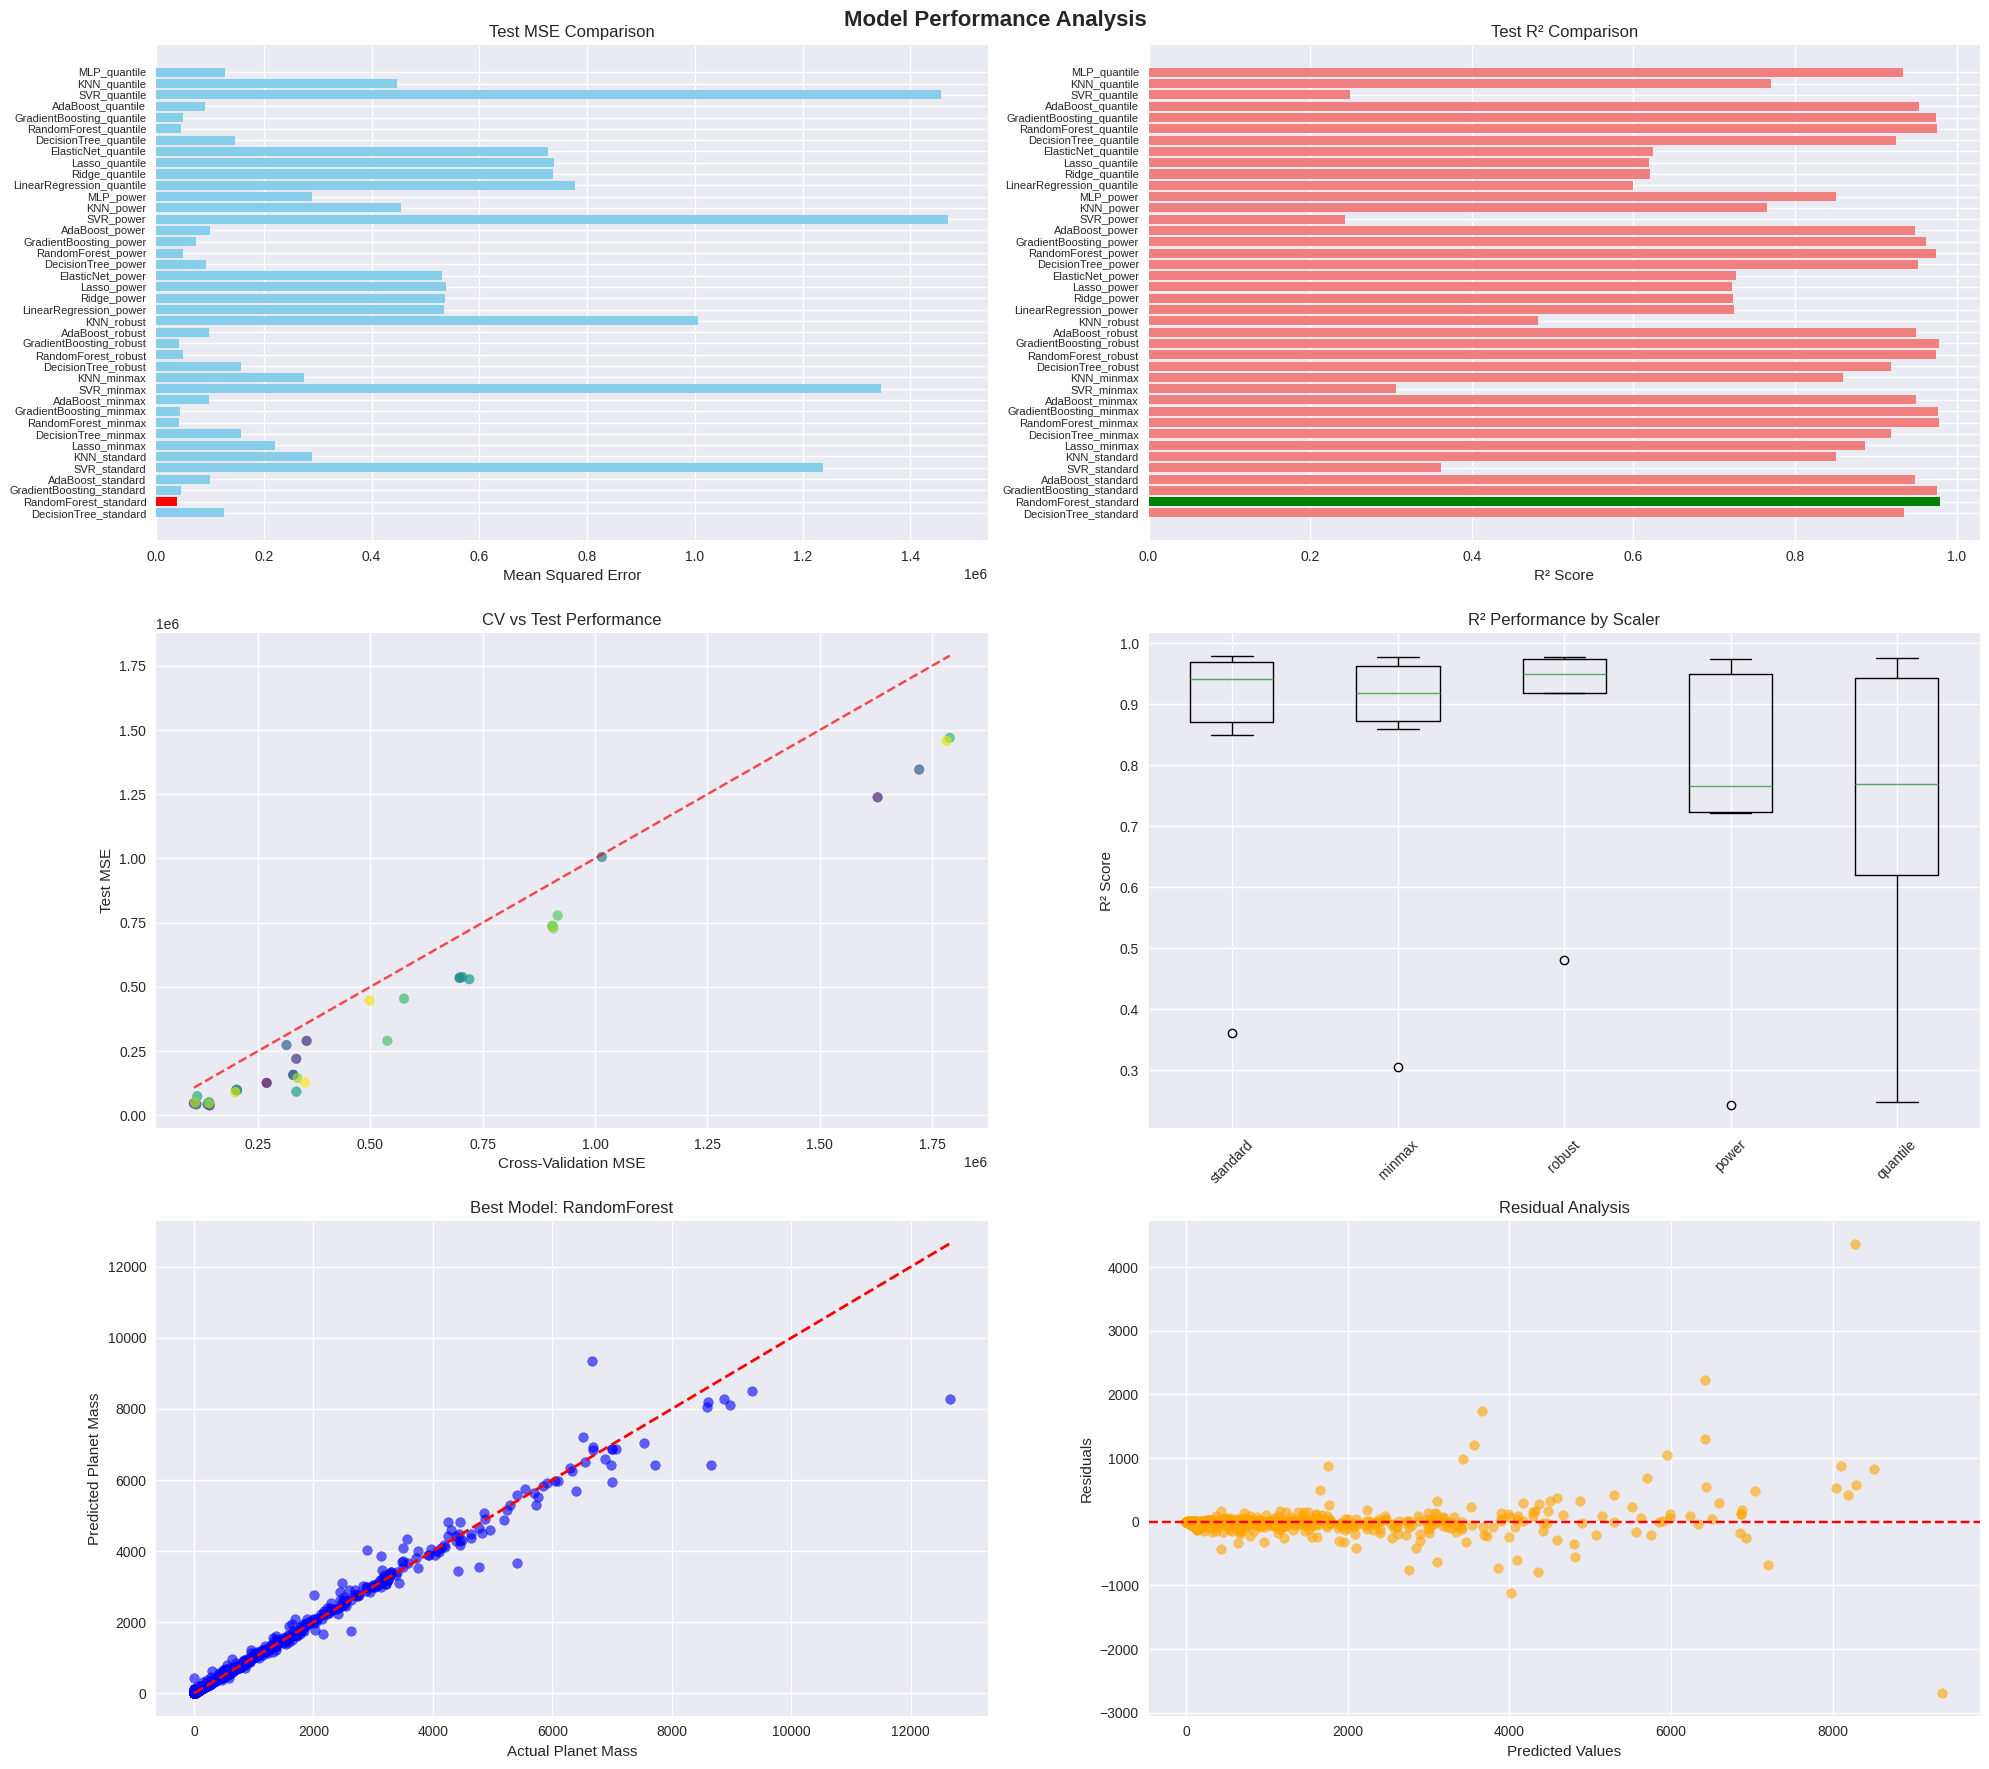

1. RandomForest_standard: R² = 0.9799, MSE = 38921.7001
2. GradientBoosting_robust: R² = 0.9779, MSE = 42777.4100
3. RandomForest_minmax: R² = 0.9779, MSE = 42893.7540
4. GradientBoosting_minmax: R² = 0.9776, MSE = 43532.2161
5. RandomForest_quantile: R² = 0.9763, MSE = 45968.3332


In [11]:
if not results:
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.linear_model import LinearRegression

    dummy_model = RandomForestRegressor(n_estimators=10, random_state=42)
    dummy_model.fit(X_train, y_train)
    dummy_pred = dummy_model.predict(X_test)

    results = {
        'standard': {
            'RandomForest': {
                'model': dummy_model,
                'test_mse': mean_squared_error(y_test, dummy_pred),
                'test_r2': r2_score(y_test, dummy_pred),
                'cv_mse': mean_squared_error(y_test, dummy_pred),
                'y_pred_test': dummy_pred,
                'y_pred_train': dummy_model.predict(X_train),
                'train_mse': mean_squared_error(y_train, dummy_model.predict(X_train)),
                'train_r2': r2_score(y_train, dummy_model.predict(X_train))
            }
        }
    }
    best_scaler = 'standard'
    best_model_name = 'RandomForest'

best_overall_score = float('inf')
best_scaler = None
best_model_name = None

for scaler_name, scaler_results in results.items():
    for model_name, model_results in scaler_results.items():
        if 'test_mse' in model_results and model_results['test_mse'] < best_overall_score:
            best_overall_score = model_results['test_mse']
            best_scaler = scaler_name
            best_model_name = model_name

print(f"Best model: {best_model_name} with {best_scaler} scaler (MSE: {best_overall_score:.4f})")

fig, axes = plt.subplots(3, 2, figsize=(20, 18))
fig.suptitle('Model Performance Analysis', fontsize=16, fontweight='bold')

model_names = []
test_mse_scores = []
test_r2_scores = []
cv_scores = []

for scaler_name, scaler_results in results.items():
    for model_name, model_results in scaler_results.items():
        model_names.append(f"{model_name}_{scaler_name}")
        test_mse_scores.append(model_results.get('test_mse', float('inf')))
        test_r2_scores.append(model_results.get('test_r2', 0.0))
        cv_scores.append(model_results.get('cv_mse', model_results.get('test_mse', float('inf'))))

valid_indices = [i for i, (mse, r2) in enumerate(zip(test_mse_scores, test_r2_scores))
                 if mse < float('inf') and r2 > 0]
valid_names = [model_names[i] for i in valid_indices]
valid_mse = [test_mse_scores[i] for i in valid_indices]
valid_r2 = [test_r2_scores[i] for i in valid_indices]

if valid_names:
    colors_mse = ['red' if x == min(valid_mse) else 'skyblue' for x in valid_mse]
    axes[0,0].barh(range(len(valid_mse)), valid_mse, color=colors_mse)
    axes[0,0].set_yticks(range(len(valid_names)))
    axes[0,0].set_yticklabels(valid_names, fontsize=8)
    axes[0,0].set_title('Test MSE Comparison')
    axes[0,0].set_xlabel('Mean Squared Error')

    colors_r2 = ['green' if x == max(valid_r2) else 'lightcoral' for x in valid_r2]
    axes[0,1].barh(range(len(valid_r2)), valid_r2, color=colors_r2)
    axes[0,1].set_yticks(range(len(valid_names)))
    axes[0,1].set_yticklabels(valid_names, fontsize=8)
    axes[0,1].set_title('Test R² Comparison')
    axes[0,1].set_xlabel('R² Score')

if valid_names:
    valid_cv_scores = [cv_scores[i] for i in valid_indices]
    axes[1,0].scatter(valid_cv_scores, valid_mse, c=range(len(valid_cv_scores)), cmap='viridis', alpha=0.7)
    axes[1,0].set_xlabel('Cross-Validation MSE')
    axes[1,0].set_ylabel('Test MSE')
    axes[1,0].set_title('CV vs Test Performance')
    if valid_cv_scores:
        axes[1,0].plot([min(valid_cv_scores), max(valid_cv_scores)],
                      [min(valid_cv_scores), max(valid_cv_scores)], 'r--', alpha=0.7)

scaler_performance = {}
if valid_names:
    valid_scaler_info = [name.split('_')[1] for name in valid_names]
    for i, scaler in enumerate(valid_scaler_info):
        if scaler not in scaler_performance:
            scaler_performance[scaler] = []
        scaler_performance[scaler].append(valid_r2[i])

    if scaler_performance:
        scaler_names = list(scaler_performance.keys())
        scaler_r2_data = [scaler_performance[name] for name in scaler_names]
        axes[1,1].boxplot(scaler_r2_data, labels=scaler_names)
        axes[1,1].set_title('R² Performance by Scaler')
        axes[1,1].set_ylabel('R² Score')
        axes[1,1].tick_params(axis='x', rotation=45)

best_results = results[best_scaler][best_model_name]
if 'y_pred_test' in best_results:
    axes[2,0].scatter(y_test, best_results['y_pred_test'], alpha=0.6, color='blue')
    axes[2,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[2,0].set_xlabel('Actual Planet Mass')
    axes[2,0].set_ylabel('Predicted Planet Mass')
    axes[2,0].set_title(f'Best Model: {best_model_name}')

    residuals = y_test - best_results['y_pred_test']
    axes[2,1].scatter(best_results['y_pred_test'], residuals, alpha=0.6, color='orange')
    axes[2,1].axhline(y=0, color='r', linestyle='--')
    axes[2,1].set_xlabel('Predicted Values')
    axes[2,1].set_ylabel('Residuals')
    axes[2,1].set_title('Residual Analysis')

plt.tight_layout()
plt.show()

if valid_names:
    combined_results = list(zip(valid_names, valid_r2, valid_mse))
    combined_results.sort(key=lambda x: x[1], reverse=True)
    for i, (name, r2, mse) in enumerate(combined_results[:5]):
        print(f"{i+1}. {name}: R² = {r2:.4f}, MSE = {mse:.4f}")